# Exercises Week 7 in 02506: Layered Surfaces

<p align="center"> 
  <img src="simple_network.png" width="300" title="Very simple NN">
</p>

### Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from make_data import make_data


### Generating Data

In [27]:
N=200
sigma = 1
example = 1
X = make_data(1,n=N, noise = sigma)

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

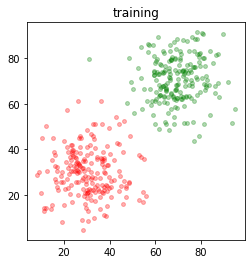

In [28]:
X, T, x, dim = make_data(example, n=N, noise=sigma)
fig, ax = plt.subplots(1,1)
ax.scatter(X[0:N,0],X[0:N,1],c = 'red', alpha = 0.3, s = 15)
ax.scatter(X[N:2*N,0],X[N:2*N,1],c = 'green', alpha = 0.3, s = 15)
ax.set_aspect('equal', 'box')
plt.title('training')
fig.show

### We Start Out by Standardizing the Data

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

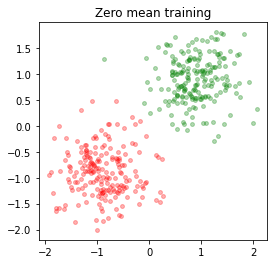

In [29]:
#%% Before training, you should make data have zero mean and std of 1
c = X.mean(axis = 0)
std = X.std(axis = 0)
x_c = (x - c)/std
X_c = (X - c)/std
    
fig, ax = plt.subplots(1,1)
ax.scatter(X_c[0:N,0],X_c[0:N,1],c = 'red', alpha = 0.3, s = 15)
ax.scatter(X_c[N:2*N,0],X_c[N:2*N,1],c = 'green', alpha = 0.3, s = 15)
ax.set_aspect('equal', 'box')
plt.title('Zero mean training')
fig.show

### Activation Function


In [30]:
def ReLU(z):
    zbar = np.zeros(z.shape)
    idx = z > 0
    zbar[idx] = z[idx]
    return zbar

def dReLU(z):
    idx = z > 0
    return idx

def Sigmoid(z):
    return 1/(1+np.exp(-z))

def Softmax(z):
    expz = np.exp(z)
    return expz/np.sum(expz)

z = np.random.normal(0,1,size=3)
print(f"z={z}")
print(f"ReLU(z)={ReLU(z)}")
print(f"Sigmoid(z)={Sigmoid(z)}")
print(f"Softmax(z)={Softmax(z)}")

z=[0.24867245 0.4077343  1.15471694]
ReLU(z)=[0.24867245 0.4077343  1.15471694]
Sigmoid(z)=[0.56184972 0.60054448 0.76037143]
Softmax(z)=[0.21519604 0.25229809 0.53250587]


### Initializing Arrays

In [31]:
def init(rows,cols=1):
    z = np.random.normal(0,1,size=(rows,cols))
    return np.sqrt(2/(rows))*z

print(f"init(4,2)={init(4,2)}")

init(4,2)=[[ 0.47678942 -0.68139048]
 [ 0.4937021   0.09082418]
 [-0.18581957  0.19171897]
 [-0.17001618 -1.03390191]]


### Defining a Linear Layer

In [32]:
class LinearLayer:
    def __init__(self,N_in,N_out):
        self.weights = init(N_out,N_in+1)
        self.N_in = N_in
        self.N_out = N_out

    def forward(self,X):
        assert(X.shape == (self.N_in,1))
        return self.weights@np.vstack((X,1))

LL1 = LinearLayer(3,4)
X = np.random.normal(-1,1,size=(3,1))
Y = LL1.forward(X)
print(f"forward({X})\n={Y}")

forward([[ 0.8177266 ]
 [-0.97663895]
 [ 0.08301981]])
=[[0.86539639]
 [1.58474429]
 [0.01811865]
 [0.79112457]]


### Defining Cross Entropy Loss


In [33]:
def argmax(z):
    return z == np.max(z)
    
def CrossEntropyLoss(Y,T):
    Y = Y.flatten()
    T = T.flatten()
    return -np.log(Y[T]+0.00000001)

T = argmax(Y)
print(f"True Class: argmax(Y)\n={T}")
print(f"CrossEntropyLoss(Y,T)={CrossEntropyLoss(Y,T)}")

True Class: argmax(Y)
=[[False]
 [ True]
 [False]
 [False]]
CrossEntropyLoss(Y,T)=[-0.46042307]


### Defining A Neural Network Class

In [34]:
class NeuralNetwork:
    def __init__(self,shapes,act_funs,diff_act_funs,seed = 1234):
        np.random.seed(seed)
        self.layers = []
        self.act_funs = act_funs
        self.diff_act_funs = diff_act_funs
        self.length = np.size(act_funs)
        assert(self.length == np.size(shapes)-1)
        self.h = []
        self.h.append(np.zeros([shapes[0],1]))
        self.a = []
        for i in range(self.length):
            self.layers.append(LinearLayer(shapes[i],shapes[i+1]))
        self.init_grads(shapes)

    def init_grads(self,shapes):
        for i in range(self.length):
            self.h.append(np.zeros([shapes[i+1],1]))
            self.a.append(np.zeros([shapes[i+1],1]))
    
    def zero_grads(self):
        self.h[0] = np.zeros(self.h[0].shape)
        for i in range(self.length):
            self.h[i+1] = np.zeros(self.h[i+1].shape)
            self.a[i] = np.zeros(self.a[i].shape)
    
    def forward(self,X):
        self.h[0] += X
        for i in range(self.length):
            X = self.layers[i].forward(X)
            self.h[i+1] += X
            self.a[i] += self.diff_act_funs[i](X)
            X = self.act_funs[i](X)
        return X

    def backward(self,Y,T,L,lr=0.01):
        d = Y-T
        h = []
        for i,hi in enumerate(self.h):
            h.append(np.vstack((hi,1)))
        W = []
        for i,layer in enumerate(self.layers):
            wi = layer.weights
            #print(f"w{i}={wi}")
            W.append(wi[:,:-1])
        for i in range(self.length-1,-1,-1):
            Q = h[i]@d.T
            if i>0:
                d = np.multiply(self.a[i-1],W[i].T@d)
            # Updating weights
            self.layers[i].weights -= lr*Q.T
            #print(i)
        
        #for i,layer in enumerate(self.layers):
            #wi = layer.weights
            #print(f"w{i}={wi}")
        self.zero_grads()

X = np.random.normal(-1,1,size=(2,1))
NN = NeuralNetwork([2,3,2],[ReLU,Softmax],[dReLU,dReLU])
Y = NN.forward(X)
T = argmax(Y)
L = CrossEntropyLoss(Y,T)
NN.backward(Y,T,L)
print(f"NN({X})\n={Y}")

NN([[-1.04578758]
 [-0.7002496 ]])
=[[0.90969357]
 [0.09030643]]


### Test and Train Splits

In [77]:
import random

train_frac = 0.8
N = 2000
example = 1
X, T, x, dim = make_data(example, n=N, noise=sigma)
c = X.mean(axis = 0)
std = X.std(axis = 0)
x_c = (x - c)/std
X_c = (X - c)/std

l = np.arange(0,2*N) # example list
random.shuffle(l) 
idx_split = np.round(train_frac*2*N).astype(int)
idx_train = l[0:idx_split]
idx_test =  l[idx_split:2*N-1]
X_train = X_c[idx_train,:]
X_test = X_c[idx_test,:]
T_train = T[idx_train,:]
T_test = T[idx_test,:]
N_train, _ = X_train.shape
N_test, _ = X_test.shape

### Training

###

In [78]:
NN = NeuralNetwork([2,30,30,2],[ReLU,ReLU,Softmax],[dReLU,dReLU,dReLU])

train_loss = []
val_loss = []

epochs = 50

for e in range(epochs):
    train_l = 0
    for i in range(N_train):
        x = X_train[i,:]
        x = x[:,None]
        y = NN.forward(x)
        t = T_train[i,:].astype(bool)
        t = t[:,None]
        l = CrossEntropyLoss(y,t)[0]
        NN.backward(y,t,l,lr=0.00001)
        train_l += l
    train_loss.append(train_l)
    val_l = 0
    for i in range(N_test):
        x = X_test[i,:]
        x = x[:,None]
        y = NN.forward(x)
        t = T_test[i,:].astype(bool)
        t = t[:,None]
        l = CrossEntropyLoss(y,t)[0]
        NN.backward(y,t,l,lr=0.00001)
        val_l += l
    val_loss.append(val_l)

preds = []
# Predictions
for i in range(N_test):
    x = X_test[i,:]
    x = x[:,None]
    y = NN.forward(x)
    preds.append(np.argmax(y))
    t = T_test[i,:].astype(bool)
    t = t[:,None]
    l = CrossEntropyLoss(y,t)[0]
    NN.backward(y,t,l,lr=0.01)

### Evaluating Results

Prob of class 1 = 0.1015
Prob of class 2 = 0.09825


<bound method Figure.show of <Figure size 864x288 with 3 Axes>>

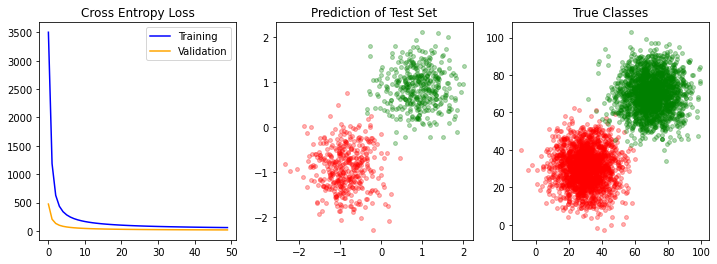

In [79]:
class1 = np.where(np.equal(preds,0))
class2 = np.where(np.equal(preds,1))
print(f"Prob of class 1 = {sum(np.equal(preds,0))/(2*N)}")
print(f"Prob of class 2 = {sum(np.equal(preds,1))/(N*2)}")

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.plot(range(0,epochs),train_loss,c = 'blue',label='Training')
ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")
ax2.scatter(X_test[class1,0],X_test[class1,1],c = 'red', alpha = 0.3, s = 15)
ax2.scatter(X_test[class2,0],X_test[class2,1],c = 'green', alpha = 0.3, s = 15)
ax2.set_title("Prediction of Test Set")
ax3.scatter(X[0:N,0],X[0:N,1],c = 'red', alpha = 0.3, s = 15)
ax3.scatter(X[N:2*N,0],X[N:2*N,1],c = 'green', alpha = 0.3, s = 15)
ax3.set_title("True Classes")
fig.show